# **Out-of-Core Single-Cell Analysis with RAPIDS-SingleCell & Dask**  
**Author:** [Severin Dicks](https://github.com/Intron7)
**Copyright** [scverse](https://scverse.org)

In this notebook, we demonstrate the **out-of-core computation** capabilities of **rapids-singlecell** using **Dask**.  
This approach allows us to analyze **1.3 million cells** efficiently, even on relatively small hardware.  

By leveraging **Dask**, we can:  
- **Process large-scale single-cell datasets** without exceeding memory limits.  
- **Enable chunk-based execution**, loading only the necessary data into memory at any time.  

This method makes **large-scale single-cell analysis feasible** on standard hardware setups,  
removing barriers to working with massive datasets.


In [2]:
import dask
import time
import gc

from dask_cuda import LocalCUDACluster
from dask.distributed import Client

In [ ]:
import rmm
import cupy as cp

from rmm.allocators.cupy import rmm_cupy_allocator

## **Initializing a Dask Cluster for Out-of-Core Computation**  

To enable **out-of-core computation** and parallel processing,  
we initialize a **Dask CUDA cluster**, which distributes computations across available GPU resource.  

### Additional parameters for `LocalCUDACluster`

- **CUDA_VISIBLE_DEVICES=preprocessing_gpus**: selects GPUs to use (e.g., `"0,1"`).
- **threads_per_worker=10**: CPU threads per GPU worker; tune for your workload and I/O.
- **protocol="ucx"**: enables UCX for high-throughput GPU-aware communication (NVLink/InfiniBand/RDMA).
- **rmm_pool_size="10GB"**: initial per-worker RAPIDS Memory Manager (RMM) pool; reduces allocation overhead.
- **rmm_maximum_pool_size="110GB"**: maximum pool growth per worker; allows RMM to expand up to this cap.
- **rmm_allocator_external_lib_list="cupy"**: integrates CuPy with RMM so CuPy allocations come from the pool.
- **Client(cluster)**: attaches the Dask client to the cluster (dashboard link available when running).

In [4]:
%%time
preprocessing_gpus="0,1"
cluster = LocalCUDACluster(CUDA_VISIBLE_DEVICES=preprocessing_gpus,
                           threads_per_worker=10,
                           protocol="ucx",
                           rmm_pool_size= "10GB",
                           rmm_maximum_pool_size = "20GB",
                           rmm_allocator_external_lib_list= "cupy",
                          )

client = Client(cluster)

client

CPU times: user 1.45 s, sys: 649 ms, total: 2.09 s
Wall time: 2.09 s


Connection method: Cluster object,Cluster type: dask_cuda.LocalCUDACluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 20,Total memory: 503.20 GiB
Status: running,Using processes: True
Comm: ucx://127.0.0.1:48531,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: ucx://127.0.0.1:47769,Total threads: 10
Dashboard: http://127.0.0.1:33327/status,Memory: 251.60 GiB
Nanny: ucx://127.0.0.1:33347,


In [5]:
import rapids_singlecell as rsc
import scanpy as sc
import anndata as ad

/home/sdicks/micromamba/envs/rapids-25.10/lib/python3.13/site-packages/scanpy/tools/__init__.py:17: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from ._louvain import louvain


## **Loading Large Datasets into AnnData with Dask**  

To efficiently handle large-scale single-cell datasets, we load data directly from an **HDF5 (`h5`) or Zarr file**  
into an **AnnData object** using **Dask arrays**. This enables **lazy loading**, allowing data to be processed in chunks  
without exceeding memory limits.  

We achieve this using **`read_elem_as_dask`**, which loads the expression matrix (`X`) as a **Dask array**

In [6]:
from packaging.version import parse as parse_version
import zarr
if parse_version(ad.__version__) < parse_version("0.12.0rc1"):
    from anndata.experimental import read_elem_as_dask as read_dask
else:
    from anndata.experimental import read_elem_lazy as read_dask


SPARSE_CHUNK_SIZE = 20_000
#data_pth = "zarr/cell_atlas.zarr" #11Million Cells
data_pth = "zarr/nvidia_1.3M.zarr" #1.3Million Cells

f = zarr.open(data_pth)
X = f["X"]
shape = X.attrs["shape"]
adata = ad.AnnData(
    X = read_dask(X, (SPARSE_CHUNK_SIZE, shape[1])),
    obs = ad.io.read_elem(f["obs"]),
    var = ad.io.read_elem(f["var"])
)

/home/sdicks/micromamba/envs/rapids-25.10/lib/python3.13/site-packages/IPython/core/interactiveshell.py:3639: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if await self.run_code(code, result, async_=asy):
/home/sdicks/micromamba/envs/rapids-25.10/lib/python3.13/site-packages/anndata/_core/anndata.py:245: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  self._init_as_actual(


In [7]:
t1 = time.time()

In [8]:
rsc.get.anndata_to_GPU(adata)

## **Transferring AnnData to GPU for Accelerated Computation**  

Once the dataset is loaded as a **Dask-backed AnnData object**,  
we transfer it to the **GPU** to leverage **RAPIDS-SingleCell’s** accelerated processing.  

We use **`rsc.get.anndata_to_GPU()`**, which efficiently moves the AnnData object to GPU memory:  


## **Quality Control (QC) Metrics Calculation (Requires Synchronization)**  

Before proceeding with further analysis, we compute **quality control (QC) metrics**  
to assess dataset quality and filter out low-quality cells or genes.  

We use **`rsc.pp.calculate_qc_metrics()`** to calculate key QC metrics

Although we are working with Dask-backed AnnData, this operation requires a synchronization step.
This means that Dask computations must be evaluated immediately,
so the process is not completely lazy like other out-of-core operations.

In [9]:
%%time
rsc.pp.calculate_qc_metrics(adata)

/home/sdicks/micromamba/envs/rapids-25.10/lib/python3.13/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound
/home/sdicks/micromamba/envs/rapids-25.10/lib/python3.13/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


CPU times: user 6.64 s, sys: 727 ms, total: 7.37 s
Wall time: 7.35 s


## **Filtering Cells and Genes Without Additional Computation**  

Instead of using **`sc.pp.filter_cells`** and **`sc.pp.filter_genes`**,  
we apply filtering directly using boolean indexing to **avoid extra computation**.

**Why Use Direct Indexing Instead of Built-in Functions?**
* More Efficient with Dask → Avoids triggering additional computations.
* Preserves Lazy Execution → Filtering is applied without forcing full dataset evaluation.
* Copy is preferred → Using `.copy()` prevents views. Views slow down computations with Dask-backed AnnData.

In [10]:
adata = adata[(adata.obs["n_genes_by_counts"]<=10000) 
            & (adata.obs["n_genes_by_counts"]>=200)].copy()

/home/sdicks/micromamba/envs/rapids-25.10/lib/python3.13/site-packages/anndata/_core/anndata.py:245: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  self._init_as_actual(


## **Log Normalization (Fully Lazy Execution)**  

Next, we apply **log normalization** to scale gene expression values.  
This step ensures that differences in sequencing depth across cells do not dominate downstream analysis.  

In [11]:
%%time
rsc.pp.normalize_total(adata,target_sum = 10000)
rsc.pp.log1p(adata)

CPU times: user 5.73 ms, sys: 969 μs, total: 6.7 ms
Wall time: 4.95 ms


## **Selecting Highly Variable Genes (Requires Synchronization)**  

To focus on the most informative features, we identify **highly variable genes (HVGs)**  
using the **Cell Ranger** method and subset the dataset accordingly.  

**Important Considerations:**
* Requires Synchronization → Computing highly variable genes triggers evaluation,
meaning this step is not fully lazy when using Dask.
* Copy is preferred → Using `.copy()` prevents views.


In [12]:
%%time
rsc.pp.highly_variable_genes(adata,n_top_genes=5000, flavor="cell_ranger")
adata = adata[:,adata.var.highly_variable].copy()

CPU times: user 5.58 s, sys: 479 ms, total: 6.05 s
Wall time: 6.04 s


/home/sdicks/micromamba/envs/rapids-25.10/lib/python3.13/site-packages/anndata/_core/anndata.py:245: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  self._init_as_actual(


## **Scaling Gene Expression (Requires Synchronization)**  

To standardize gene expression values, we apply **feature scaling**,  
ensuring that all genes contribute equally to downstream analysis.

**Important Considerations:**
* Requires Synchronization → Since the input matrix is in CSR format (Compressed Sparse Row),
this step forces an immediate computation, meaning it is not fully lazy like earlier transformations.
* Scaling → Divides each gene’s expression values by its standard deviation.
* zero_center=False → Keeps the scaled values non-centered,
which is beneficial for sparse matrices and GPU acceleration.


In [13]:
%%time
rsc.pp.scale(adata, zero_center= False)

CPU times: user 5.56 s, sys: 462 ms, total: 6.02 s
Wall time: 6.01 s


## **Principal Component Analysis (PCA) on GPU (Two-Step Synchronization Process)**  

To reduce dimensionality while preserving meaningful variation,  
we perform **Principal Component Analysis (PCA)** using **GPU acceleration**.

Understanding the Two-Step Synchronization in PCA:
1. Mandatory Synchronization for Covariance & Mean Calculation
    * PCA requires computing the covariance matrix and mean vector,
    which must be explicitly synchronized before proceeding.
    * This step is handled automatically within `rsc.pp.pca()`.

2. Finalizing the Transformation with `.compute()`
    * After computing the principal components, the data remains lazy (Dask CuPy array).
    * Calling `.compute()` on `adata.obsm["X_pca"]` performs the final transformation,
      projecting the data onto the computed PCs and materializing the result as a fully computed CuPy array.

**Why This Matters?**
* The first synchronization (**covariance & mean**) ensures the PCA model is ready.
* The second synchronization (`compute()`) ensures that the transformed data is fully realized
for downstream analyses like clustering and UMAP.

In [14]:
%%time
rsc.pp.pca(adata, n_comps = 100,mask_var=None)
adata.obsm["X_pca"]=adata.obsm["X_pca"].compute()

CPU times: user 12.9 s, sys: 1.75 s, total: 14.7 s
Wall time: 14.5 s


In [15]:
print(f"Time for the notebook: {time.time()-t1}s")

Time for the notebook: 34.43392086029053s


In [16]:
adata.obsm["X_pca"] = adata.obsm["X_pca"].get()

In [17]:
%%time
rsc.pp.neighbors(adata, n_neighbors=15, n_pcs=50, algorithm="ivfflat")

CPU times: user 2.02 s, sys: 318 ms, total: 2.33 s
Wall time: 2.13 s


In [18]:
%%time
rsc.tl.umap(adata)

CPU times: user 849 ms, sys: 169 ms, total: 1.02 s
Wall time: 798 ms


In [19]:
%%time
rsc.tl.leiden(adata)

CPU times: user 2.11 s, sys: 1.18 s, total: 3.29 s
Wall time: 2.86 s


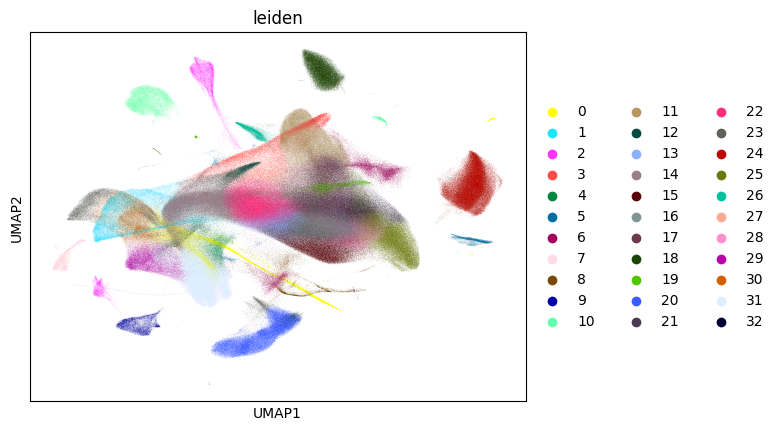

In [20]:
sc.pl.umap(adata, color="leiden")